# Radio Images
Transmitting images over radio



In [3]:
%pylab
# Import functions and libraries
import numpy as np
import matplotlib.pyplot as plt
import pyaudio
import Queue
import threading,time
import sys

from numpy import pi
from numpy import sin
from numpy import zeros
from numpy import r_
from numpy import ones
from scipy import signal
from scipy import integrate
from __future__ import division

import threading,time
import multiprocessing

from rtlsdr import RtlSdr
from numpy import mean
from numpy import power
from numpy.fft import fft
from numpy.fft import fftshift
from numpy.fft import ifft
from numpy.fft import ifftshift
import bitarray
from  scipy.io.wavfile import read as wavread
import serial

%matplotlib inline

Using matplotlib backend: Qt4Agg
Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


For the following tasks you will need the functions:

`sg_plot`  included in lab7.py

`myspectrogram_hann_ovlp` included in lab7.py

`play_audio` included in lab7.py

`record_audio`  included in lab7.py

`printDevNumbers`  included in lab7.py

`text2Morse` (to Identify yourself before transmission)

`afsk1200` (from the previous lab)

`nc_afskDemod` (from the previous lab)

In [4]:
# Plot an image of the spectrogram y, with the axis labeled with time tl,
# and frequency fl
#
# t_range -- time axis label, nt samples
# f_range -- frequency axis label, nf samples
# y -- spectrogram, nf by nt array
# dbf -- Dynamic range of the spect

def sg_plot( t_range, f_range, y, dbf = 60) :
    eps = 1e-3
    
    # find maximum
    y_max = abs(y).max()
    
    # compute 20*log magnitude, scaled to the max
    y_log = 20.0 * np.log10( abs( y ) / y_max + eps )
    
    fig=figure(figsize=(15,6))
    
    plt.imshow( np.flipud( 64.0*(y_log + dbf)/dbf ), extent= t_range  + f_range ,cmap=plt.cm.gray, aspect='auto')
    plt.xlabel('Time, s')
    plt.ylabel('Frequency, Hz')
    plt.tight_layout()


def myspectrogram_hann_ovlp(x, m, fs, fc,dbf = 60):
    # Plot the spectrogram of x.
    # First take the original signal x and split it into blocks of length m
    # This corresponds to using a rectangular window %
    
    
    isreal_bool = isreal(x).all()
    
    # pad x up to a multiple of m 
    lx = len(x);
    nt = (lx + m - 1) // m
    x = append(x,zeros(-lx+nt*m))
    x = x.reshape((m/2,nt*2), order='F')
    x = concatenate((x,x),axis=0)
    x = x.reshape((m*nt*2,1),order='F')
    x = x[r_[m//2:len(x),ones(m//2)*(len(x)-1)].astype(int)].reshape((m,nt*2),order='F')
    
    
    xmw = x * hanning(m)[:,None];
    
    
    # frequency index
    t_range = [0.0, lx / fs]
    
    if isreal_bool:
        f_range = [ fc, fs / 2.0 + fc]
        xmf = np.fft.fft(xmw,len(xmw),axis=0)
        sg_plot(t_range, f_range, xmf[0:m/2,:],dbf=dbf)
        print 1
    else:
        f_range = [-fs / 2.0 + fc, fs / 2.0 + fc]
        xmf = np.fft.fftshift( np.fft.fft( xmw ,len(xmw),axis=0), axes=0 )
        sg_plot(t_range, f_range, xmf,dbf = dbf)
    
    return t_range, f_range, xmf

def play_audio( Q, p, fs , dev, ser="", keydelay=0.200):
    # play_audio plays audio with sampling rate = fs
    # Q - A queue object from which to play
    # p   - pyAudio object
    # fs  - sampling rate
    # dev - device number
    # ser - pyserial device to key the radio
    # keydelay - delay after keying the radio
    
    # Example:
    # fs = 44100
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # Q = Queue.queue()
    # Q.put(data)
    # Q.put("EOT") # when function gets EOT it will quit
    # play_audio( Q, p, fs,1 ) # play audio
    # p.terminate() # terminate pyAudio
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),output=True,output_device_index=dev)
    # play audio
    while (1):
        data = Q.get()
        if data=="EOT"  :
            break
        elif (data=="KEYOFF"  and ser!=""):
            time.sleep(keydelay)
            ser.setDTR(0)
            #print("keyoff\n")
        elif (data=="KEYON" and ser!=""):
            ser.setDTR(1)  # key PTT
            #print("keyon\n")
            time.sleep(keydelay) # wait 200ms (default) to let the power amp to ramp up
            
        else:
            try:
                ostream.write( data.astype(np.float32).tostring() )
            except:
                print("Exception")
                break
            
def record_audio( queue, p, fs ,dev,chunk=1024):
    # record_audio records audio with sampling rate = fs
    # queue - output data queue
    # p     - pyAudio object
    # fs    - sampling rate
    # dev   - device number 
    # chunk - chunks of samples at a time default 1024
    #
    # Example:
    # fs = 44100
    # Q = Queue.queue()
    # p = pyaudio.PyAudio() #instantiate PyAudio
    # record_audio( Q, p, fs, 1) # 
    # p.terminate() # terminate pyAudio
    
   
    istream = p.open(format=pyaudio.paFloat32, channels=1, rate=int(fs),input=True,input_device_index=dev,frames_per_buffer=chunk)

    # record audio in chunks and append to frames
    frames = [];
    while (1):
        try:  # when the pyaudio object is distroyed stops
            data_str = istream.read(chunk) # read a chunk of data
        except:
            break
        data_flt = np.fromstring( data_str, 'float32' ) # convert string to float
        queue.put( data_flt ) # append to list

def text2Morse(text,fc,fs,dt):
    CODE = {'A': '.-',     'B': '-...',   'C': '-.-.', 
        'D': '-..',    'E': '.',      'F': '..-.',
        'G': '--.',    'H': '....',   'I': '..',
        'J': '.---',   'K': '-.-',    'L': '.-..',
        'M': '--',     'N': '-.',     'O': '---',
        'P': '.--.',   'Q': '--.-',   'R': '.-.',
     	'S': '...',    'T': '-',      'U': '..-',
        'V': '...-',   'W': '.--',    'X': '-..-',
        'Y': '-.--',   'Z': '--..',
        
        '0': '-----',  '1': '.----',  '2': '..---',
        '3': '...--',  '4': '....-',  '5': '.....',
        '6': '-....',  '7': '--...',  '8': '---..',
        '9': '----.',

        ' ': ' ', "'": '.----.', '(': '-.--.-',  ')': '-.--.-',
        ',': '--..--', '-': '-....-', '.': '.-.-.-',
        '/': '-..-.',   ':': '---...', ';': '-.-.-.',
        '?': '..--..', '_': '..--.-'
        }
    
    Ndot= 1.0*fs*dt
    Ndah = 3*Ndot
    
    sdot = sin(2*pi*fc*r_[0.0:Ndot]/fs)
    sdah = sin(2*pi*fc*r_[0.0:Ndah]/fs)
    
    # convert to dit dah
    mrs = ""
    for char in text:
        mrs = mrs + CODE[char.upper()] + "*"
    
    sig = zeros(1)
    for char in mrs:
        if char == " ":
            sig = concatenate((sig,zeros(Ndot*7)))
        if char == "*":
            sig = concatenate((sig,zeros(Ndot*3)))
        if char == ".":
            sig = concatenate((sig,sdot,zeros(Ndot)))
        if char == "-":
            sig = concatenate((sig,sdah,zeros(Ndot)))
    return sig
            

def printDevNumbers(p):
    N = p.get_device_count()
    for n in range(0,N):
        name = p.get_device_info_by_index(n).get('name')
        print n, name
        


Copy and paste your afsk1200 and nc_afskDemod functions here:

In [5]:
# copy and paste your own functions here. 

def afsk1200(bits):
    #the function will take a bitarray of bits and will output an AFSK1200 modulated signal of them, sampled at 44100Hz
    fs = 44100*4
    baud = 1200
    fc = 1700
    delf = 500
    
    bits = np.array(bits.tolist())
    
    #print bits < 1
    
    bits = bits.astype(int)
    
    np.place(bits, bits < 1, [-1])
    
    #print bits
    
    #width, height = figaspect(0.2)
    #fig = figure(figsize=(width,height))

    #plot(np.r_[0:bits.size], bits)

    #your code here
    sperb = fs/baud
    
    t = np.r_[0:bits.size*sperb]
    integ = integrate.cumtrapz(np.repeat(bits, sperb), initial=0)
    
    #fig = figure(figsize=(width,height))
    #plot(np.r_[0:integ.size], integ)
    
    ph = t*2*pi*fc/fs + integ*2*pi*delf/fs
    
    sig = real(exp(1j*ph[::4]))
    
    return sig
        
              


def nc_afskDemod(sig, TBW=2.0, N=74):
    #  non-coherent demodulation of afsk1200
    # function returns the NRZI (without rectifying it)
    
    # your code here
    
    # Generate filters
    
    fs = 44100
    TBW = 2
    N = 147
    BW = 1200/fs
    lowpass = signal.firwin(N, BW)
    t = np.r_[0:N]
    h_space = exp(1j*t*2*pi*2200/fs)*lowpass
    h_mark = exp(1j*t*2*pi*1200/fs)*lowpass
    
    sig_space = signal.fftconvolve(sig, h_space)
    sig_mark = signal.fftconvolve(sig, h_mark)
    
    #NRZI = np.absolute(sig_mark) - np.absolute(sig_space)
    
    #return NRZI > -0.02
   
    mark = np.absolute(sig_mark)
    space = np.absolute(sig_space)

    NRZI = (mark-space)
    return NRZI



Now, similarly to before, find the audio interface numbers. And intitialize the variables:
dusb_in, dusb_out, din, dout 



In [6]:
        
p = pyaudio.PyAudio()
printDevNumbers(p)
p.terminate()

0 HDA NVidia: CS4206 Analog (hw:0,0)
1 HDA NVidia: CS4206 Digital (hw:0,1)
2 HDA NVidia: HDMI 0 (hw:0,3)
3 HDA NVidia: HDMI 0 (hw:0,7)
4 HDA NVidia: HDMI 0 (hw:0,8)
5 sysdefault
6 front
7 surround21
8 surround40
9 surround51
10 surround71
11 iec958
12 spdif
13 hdmi
14 pulse
15 dmixout
16 dmix
17 default


In [5]:
# CHANGE!!!!
dusb_in = 1
dusb_out = 5
din = 2
dout = 7

Initialize serial port

In [40]:
if sys.platform == 'darwin':  # Mac
    s = serial.Serial(port='/dev/tty.SLAB_USBtoUART')
else:                         #windows
    s = serial.Serial(port='COM7') # CHANGE !!!!!!

In [14]:
def play_audio_direct( data, p, fs):
    # data - audio data array
    # p    - pyAudio object
    # fs    - sampling rate
    
    # open output stream
    ostream = p.open(format=pyaudio.paFloat32, channels=1, rate=fs,output=True)
    # play audio
    ostream.write( data.astype(np.float32).tostring() )

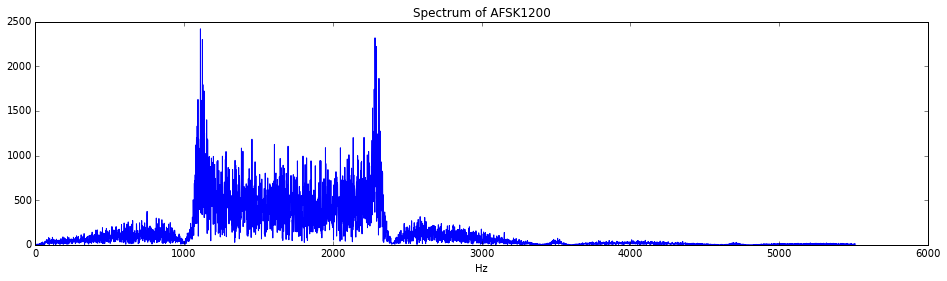

In [16]:
# construct message
bitarray.bitarray()

bits= bitarray.bitarray(list(np.random.random(10000) > 0.5))
msg = afsk1200(bits)



# display spectrogram
fig = figure(figsize(16,4))
plot(linspace(0,22050/4,20000/4),abs(np.fft.fft(msg,n=40000))[:20000/4])

xlabel('Hz')
title('Spectrum of AFSK1200')


# play message on your speaker
# instantiate PyAudio
p = pyaudio.PyAudio()
# play sound
play_audio_direct( msg, p, 44100 )

# terminate pyAudio
p.terminate()


bitarray('0010100110000110101111001010110111111101011100010110000110100101001000011100101110101000000010010001')

* Tune your radio to the APRS national frequency: 144.39MHz or Channel 117 on your radio. 
* Send the APRS packet through your radio. As always it is better to be outside in a high place. If you are near Cory Hall you should be OK, we have an APRS internet gateway in Cory.
* Sometimes it is useful to send the packet twice, just to make sure it goes through. 
* Be very carefull that your radio is operating appropriately, i.e., not getting stuck in transmit etc. We do not wish to interfere with the APRS network!

